In [3]:
# install dependencies
!pip install casadi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 MB 8.3 MB/s eta 0:00:00


# Safe Autonomy Tutorial: 2D Drone Example

In this tutorial, you will be getting comfortable with Colab notebooks and do some basic exercises in python to get back into the swing of things! You will also get an introduction to the running example used throughout the course, taking a look at the dynamics model of a 2D drone and run some initial simulations.

## Exercise 0


* Take a look at the [Basic Colab Feature Overview](https://colab.research.google.com/notebooks/basic_features_overview.ipynb). You will probably not need all of the mentioned features.
* The following exercises and tutorials will require basic python knowledge. If you need a quick refresher, check out this [Python Tutorial](https://colab.research.google.com/github/cs231n/cs231n.github.io/blob/master/python-colab.ipynb).


## Exercise 1 - Python Warm-up

The Fibonacci numbers are the sequence of numbers $\{F_n\}_{n=1}^\infty$ defined by the linear recurrence equation

$$F_n = F_{n-1} + F_{n-2}$$

with $F_1 = F_2 = 1$, and conventionally defining $F_0 = 0$. We can thus calculate some of the first few Fibonacci numbers as 0, 1, 1, 2,
3, 5, 8, 13, 21, ... and so forth.

1. Create a code cell under this text cell.
2. Write a recursive python function that returns the n-th fibonnaci number, where n is given as an input parameter.
3. Print some example results using your function.

### Voluntary Bonus
When computing all fibonacci numbers from 0 to n, it is not very efficient to call the recursive function multiple times. Write a more efficient version by either caching previous results and/or generating the numbers in an iterative fashion.

In [4]:
def fibo(n):
  curr_num = 1
  prev_num = 0
  fibo_arr = []
  for i in range(n):
    # print("curr_num, prev_num")
    # print(curr_num, prev_num)
    if i == 0:
      fibo_arr.append(0)
      continue
    curr_num = curr_num + prev_num
    prev_num = curr_num - prev_num
    fibo_arr.append(curr_num)
  return fibo_arr


fibo_arr = fibo(10)
print(fibo_arr)

[0, 1, 2, 3, 5, 8, 13, 21, 34, 55]


## Exercise 2 - Plotting

[matplotlib](https://matplotlib.org/) is a powerful python library that features a multitude of plotting functionalities. For examples on how to use it, check the tutorials mentioned in exercise 0.


1. Plot the graph of the first 100 fibonacci numbers, with $n$ on the x-axis and $F_n$ on the y-axis.
2. Make sure to label all axes and give your plot a heading.


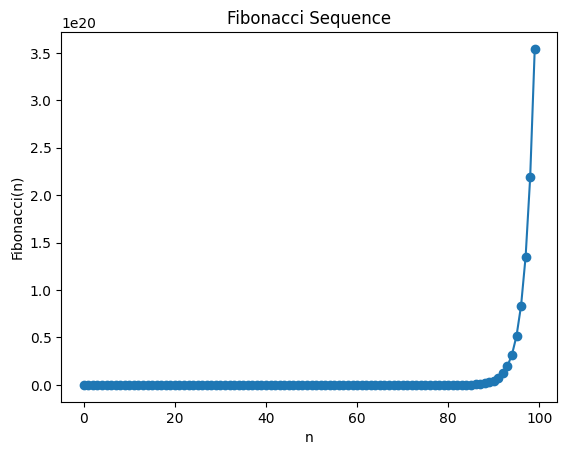

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


# PUT YOUR CODE HERE
fig,ax = plt.subplots()
ax.set_xlabel('n')
ax.set_ylabel('Fibonacci(n)')
n = 100
x = range(n)
y = fibo(n)
ax.plot(x, y, 'o-')
plt.title('Fibonacci Sequence')
plt.show()


## Continuous-time dynamics

In this section, we're gonna have a look at the dynamics model of a 2D drone which is typically needed for verification or controller synthesis which is a big part of this course. The true dynamics of a drone, or any other classic robotic system, can be obtained by using Newton and Euler Equations. For now,
we consider a simplified kinematic model of the drone:

$$
\begin{align}
    \begin{bmatrix}
    \dot{x}\\
    \dot{y}\\
    \dot{\theta}
    \end{bmatrix} = \begin{bmatrix}
    - u_1 \sin(\theta)\\
    u_1 \cos(\theta)\\
    u_2
    \end{bmatrix}
\end{align}
$$

Note that our dynamical system $\dot{\mathbf{x}} = \mathbf{f} (\mathbf{x}, \mathbf{u})$ is defined by a three dimensional state vector $\mathbf{x} \in \mathbb{R}^3$ and a two dimensional control input $\mathbf{u} \in \mathbb{R}^2$. Here, the control input $u_1$ corresponds to the velocity in the direction of the drones heading and $u_2$ allows us to control the drone's angular velocity.

Let's import some packages and define the dynamics of the Drone as a callable function!

In [6]:
import numpy as np
from math import *


def dynamics(x, u):
    """
    Inputs: current state of the system x, control input u
    u = [u1, u2]
    x = [x, y, theta]
    Output: derivative of the state vector
    dx = [dx, dy, dtheta]
    """

    # PUT YOUR CODE HERE

    dx = [-u[0]*sin(x[2]) , u[0]*cos(x[2]), u[1]]
    return dx

Next, let us explore how our dynamical system behaves under a certain control input. Let's consider the case where the drone is oriented in an upright position and the thrusters are generating a sinusoidal velocity profile. In this case we will define our control input as

In [7]:
def control_input(x, t):
    return np.array([0.5 * sin(5 * t), 0.0])

What we are interested in now is how our dynamical system in (1) evolves over time given our control signal $\mathbf{u}(t)$. To do so, we need to solve the ordinary differential equation (1) which is essentially an initial value problem (IVP).

In [8]:
from scipy.integrate import solve_ivp


# Define controlled vector field F(x)
F = lambda t, x: dynamics(x, control_input(x, t))

print(F)
# define time span
tspan = [0., 5.]

# define initial state
x0 = np.array([0., 0., 0.])

# solve IVP
sol = solve_ivp(F, tspan, x0, t_eval=np.arange(tspan[0], tspan[1], 0.01))

print("Solution shape: " + str(sol.y.shape))

<function <lambda> at 0x7c536f0095a0>
Solution shape: (3, 500)


Now, we can have a look at the state evolution over time. We are expecting to see a sinusoidal movement in $y$-direction, while the other states remain zero.

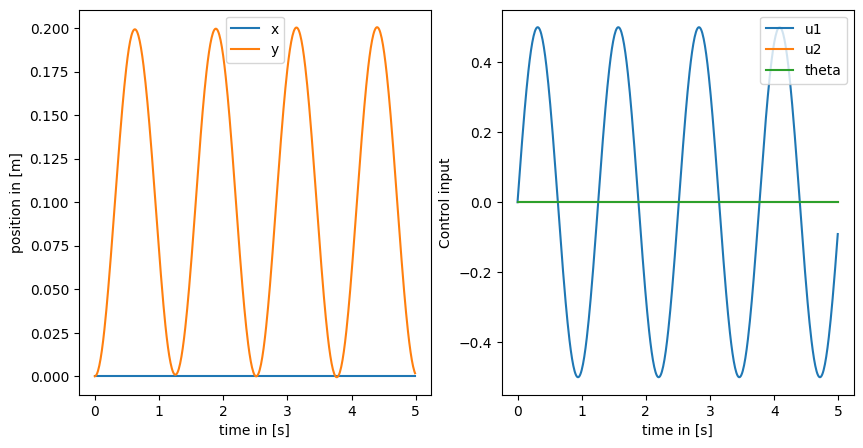

In [9]:
import matplotlib.pyplot as plt

x_data = sol.y[0, :]
y_data = sol.y[1, :]
theta_data = sol.y[2, :]
t = sol.t

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
ax1.plot(t, x_data)
ax1.plot(t, y_data)
ax1.set_xlabel("time in [s]")
ax1.set_ylabel("position in [m]")
ax1.legend(["x", "y"])

# Extract controls
u1 = [control_input(sol.y[:, i], t[i])[0] for i in range(len(t))]
u2 = [control_input(sol.y[:, i], t[i])[1] for i in range(len(t))]

ax2 = fig.add_subplot(122)
ax2.plot(t, u1)
ax2.plot(t, u2)
ax2.plot(t, theta_data)
ax2.set_xlabel("time in [s]")
ax2.set_ylabel("Control input")
ax2.legend(["u1", "u2", "theta"])

We can also create a small visualization of the drone as follows

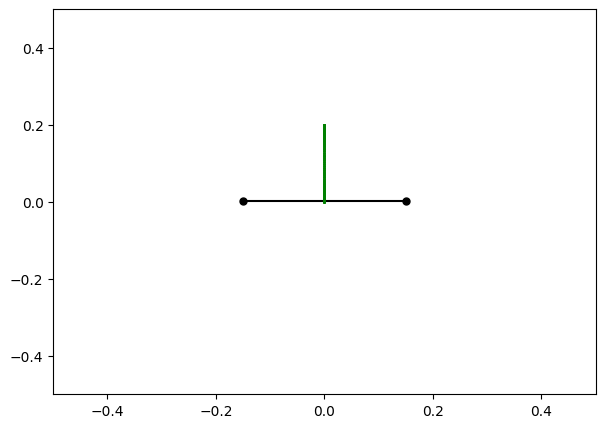

In [10]:
%matplotlib inline
from matplotlib.animation import FuncAnimation
from IPython.display import HTML


def animation_func(i, data):
    x = data[0]
    y = data[1]
    theta = data[2]
    # Drone dimension: width l
    l = 0.3
    p1 = [x[i] + cos(theta[i]) * l/2, y[i] + sin(theta[i]) * l/2]
    p2 = [x[i] - cos(theta[i]) * l/2, y[i] - sin(theta[i]) * l/2]
    line1.set_xdata([p1[0], p2[0]])
    line1.set_ydata([p1[1], p2[1]])
    # Plot trajectory
    pt, = ax.plot([x[i]], [y[i]], "g.", markersize=1)

    return line1, pt

# print(len(t))
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
ax.set_xlim([-0.5, 0.5])
ax.set_ylim([-0.5, 0.5])
line1, = ax.plot([-0.15, 0.15], [0., 0.], 'ko-', lw=1.5, markersize=5)

animation = FuncAnimation(fig, animation_func, fargs=((x_data, y_data, theta_data),),
                          frames=len(t), interval=20, blit=True)

# render in google colab
HTML(animation.to_html5_video())


## Discrete-time Dynamics

Continuous-time dynamics are most often used on a rather lower level of a robotic system, as for example in control design. The true dynamical system will of course evolve in continuous time but in order to create sophisticated planning algorithms, we are interested in abstractions of the system which simplify our calculations. A very common approach is to consider the discrete-time dynamics of a robot in which we only consider the state of the robot at specific points in time, i.e. $\mathbf{x}_k = \mathbf{x}(t_k)$. Another important argument why one should consider the discrete time dynamics is that our planning & control algorithms are implemented on computers & micro-controllers which cannot generate continuous time signals which means that our inputs to the robot are always on a discrete level.

In many applications, we start to model our robotic system in continuous time $\dot{\mathbf{x}} = \mathbf{f}(\mathbf{x}, \mathbf{u})$ using, e.g. Newton Euler equations, and discretize the dynamics using an explicit Euler scheme where we leverage finite differences to approximate
$$
    \dot{\mathbf{x}} \approx \frac{\mathbf{x}_{k+1} - \mathbf{x}_{k}}{\Delta t}, \hspace{1cm} \Delta t = t_{k+1} -t_k
$$
where $\Delta t$ is a constant sampling time. Therefore, we can obtain the time-discretized dynamics as
$$
    \mathbf{x}_{k+1} = \mathbf{x}_{k} + \Delta t \cdot \mathbf{f}(\mathbf{x}_k, \mathbf{u}_k)
$$
and hence our discrete-time drone dynamics are given by
$$
\begin{bmatrix}
    x_{k+1}\\
    y_{k+1}\\
    \theta_{k+1}
    \end{bmatrix} = \begin{bmatrix}
    x_k - u_1 \Delta t sin(\theta)\\
    y_k + u_1 \Delta t cos(\theta)\\
     \theta _k + u_2 \Delta t
    \end{bmatrix}.
$$


The great advantage of using discrete-time dynamics is that we can easily simulate our system since we don't need to solve a differential equation anymore.

In [12]:
def discrete_dynamics(x, u):
    """
    Inputs: current state of the system x, control input u
    x = [x_prev, y_prev, theta_prev]
    u = [u1, u2]
    Output: next state vector
    """
    dt = 0.1
    # PUT YOUR CODE HERE
    x_state_next = x[0] -u[0]*sin(x[2])*dt
    y_next = x[1] + u[0]*cos(x[2])*dt
    theta_next = x[2] + u[1]*dt
    x_next = [x_state_next, y_next, theta_next]
    return x_next

Now, we will solve our first planning problem in which we want to find a path to a desired goal position. To do so, we utilize trajectory optimization concepts. The problem we want to solve can be mathematically formulated as

$$
\begin{aligned}
	\min_{\mathbf{u}_{1:N-1}, \mathbf{x}_{1:N}} \quad &\sum_{t=1}^{N} J(\mathbf{x}_t, \mathbf{u}_t)\\
	\textrm{s.t.  } \quad  &\mathbf{x}_{t+1} = \mathbf{f}\left(\mathbf{x}_t, \mathbf{u}_t\right) \hspace{0.5cm} &&\forall t = 1, \cdots, N-1\\
	& \mathbf{x}_N \in \mathcal{X}_g, \mathbf{x}_0 = \mathbf{x}(t_0)\\
    \quad &0 \leq u_1 \leq 0.5 &&\forall t=1, \cdots, N-1.
    \end{aligned}
$$
To formulate and solve the optimization problem, we make use of an efficient open source nonlinear optimization tool called CasADi. This toolbox allows us to easily formulate and solve an optimization problem without diving into the theory of optimization. Some of the structure is already given in the following codeblock, what you need to do is to define the constraints of the optimization problem.

In [18]:
import casadi

opti = casadi.Opti()

# Trajectory length
N = 100
dt = 0.1

# Initial & Goal states
x0 = [0., 0., 0.]
xG = [1.5, 1.0, 0.]


# state trajectory
X = opti.variable(3, N)

# controls
U = opti.variable(2,N)

opti.minimize(sum([(X[0, i] - xG[0])**2 + (X[1, i] - xG[1])**2 + (X[2, i] - xG[2])**2 + 5*U[0, i]**2 + 2*U[1, i]**2 for i in range(N)]))

# Dynamics constraints
for k in range(N-1):
    opti.subject_to(X[0, k+1] - X[0, k] - U[0, k] * dt * casadi.sin(X[2, k]) == 0)
    opti.subject_to(X[1, k+1] - X[1, k] + U[0, k] * dt * casadi.cos(X[2, k]) == 0)
    opti.subject_to(X[2, k+1] - X[2, k] + U[1, k] * dt == 0)

# Initial State Constraints
opti.subject_to(X[:,0] == x0)

# Goal Constraints
opti.subject_to(X[:, N-1] == xG)


# Actuator saturation constraints
for k in range(N-1):
    opti.subject_to(0 <= U[0, k+1])
    opti.subject_to(U[0, k+1] <= 0.5)

opti.solver('ipopt')
sol = opti.solve()

traj = sol.value(X)
controls = sol.value(U)

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1095
Number of nonzeros in inequality constraint Jacobian.:      198
Number of nonzeros in Lagrangian Hessian.............:      599

Total number of variables............................:      500
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      303
Total number of inequality constraints...............:      198
        inequality constraints with only lower bounds:       99
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       99

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.2500000e+02 1.50e+00 3.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

After solving the optimization problem, we can visualize our drone again:

Text(0, 0.5, 'Control input')

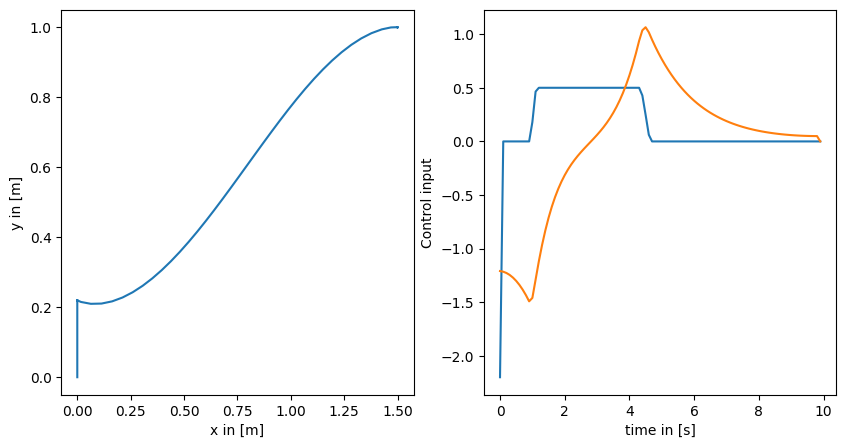

In [19]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
ax1.plot(traj[0, :], traj[1, :])
ax1.set_xlabel("x in [m]")
ax1.set_ylabel("y in [m]")

# Extract controls
u1 = controls[0, :]
u2 = controls[1, :]
t = [i * dt for i in range(N)]
ax2 = fig.add_subplot(122)
ax2.plot(t, u1)
ax2.plot(t, u2)
ax2.set_xlabel("time in [s]")
ax2.set_ylabel("Control input")

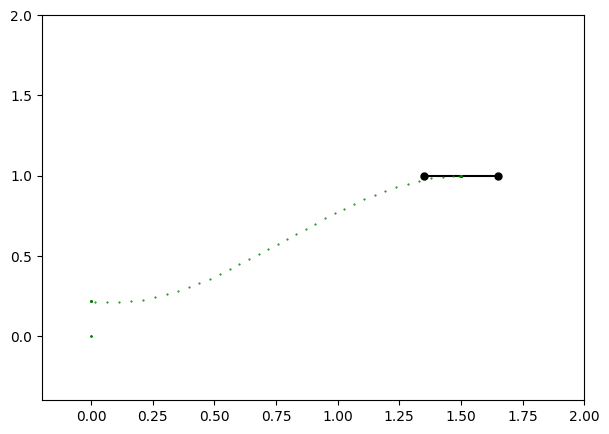

In [21]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
ax.set_xlim([-0.2, 2.])
ax.set_ylim([-0.4, 2.])
line1, = ax.plot([x0[0]-0.15, x0[0] + 0.15], [0., 0.], 'ko-', lw=1.5, markersize=5)

x_data = traj[0, :]
y_data = traj[1, :]
theta_data = traj[2, :]
animation = FuncAnimation(fig, animation_func, fargs=((x_data, y_data, theta_data),),
                          frames=len(t), interval=20, blit=True)

HTML(animation.to_html5_video())